# Fraud Prevention Intelligent Platform(FPIP)

In [40]:
import pandas as pd # for dataframe and tabular data
from sklearn.neighbors import KNeighborsClassifier

# Data Visualizations libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning libraries
import xgboost as xgb 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score # For splitting data and cross-validation
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, make_scorer # # For evaluating models
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import imblearn
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import lazypredict
from lazypredict.Supervised import LazyClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import pandas as pd


key Variables:
index - Unique Identifier for each row
trans_date_trans_time - Transaction DateTime
cc_num - Credit Card Number of Customer
merchant - Merchant Name
category - Category of Merchant
amt - Amount of Transaction
first - First Name of Credit Card Holder
last - Last Name of Credit Card Holder
gender - Gender of Credit Card Holder
street - Street Address of Credit Card Holder
city - City of Credit Card Holder
state - State of Credit Card Holder
zip - Zip of Credit Card Holder
lat - Latitude Location of Credit Card Holder
long - Longitude Location of Credit Card Holder
city_pop - Credit Card Holder's City Population
job - Job of Credit Card Holder
dob - Date of Birth of Credit Card Holder
trans_num - Transaction Number
unix_time - UNIX Time of transaction
merch_lat - Latitude Location of Merchant
merch_long - Longitude Location of Merchant
is_fraud - Fraud Flag <--- Target Class

<h3 style="color: black; font-weight: bold;">1 | ETL </h3>

<h5 style="color: black; font-weight;">1.1 & 1.2 | Using Classes for Loading and Cleaning the Dataset</h5>


In [41]:
class DataLoader:
    def __init__(self, file_path_train,file_path_test):
        self.file_path_train = file_path_train
        self.file_path_test = file_path_test
        self.df_train = None
        self.df_test = None

    def load_data(self):
        """Loading the Dataset"""
        self.df_train = pd.read_csv(self.file_path_train)
        self.df_test = pd.read_csv(self.file_path_test)
        
        combined_train_test_data = pd.concat([self.df_train, self.df_test], ignore_index=True)
        return combined_train_test_data

class DataExplorer:
    def __init__(self,combined_train_test_data):
        self.df_train_test = combined_train_test_data
        
        """Data Exploration - Initial exploration of the dataset"""
        print("Data Exploration - Combined Data")
        print("\nShape of the dataset:", self.df_train_test.shape)  # Shape of the combined data
        print("\nColumns in the dataset:")
        print(self.df_train_test.columns) # Checking the columns
        print("\nData Types of each column:") # Checking the dtypes
        print(self.df_train_test.dtypes)
        print("\nInformation about the DataFrame:")
        self.df_train_test.info() 
        print("\nFirst 5 rows of the dataset:")
        print(self.df_train_test.head())
        
        # Transforming columns 'dob' and 'trans_date_trans_time' to datetime
        self.df_train_test['dob'] = pd.to_datetime(self.df_train_test['dob'], errors='coerce')
        self.df_train_test['trans_date_trans_time'] = pd.to_datetime(self.df_train_test['trans_date_trans_time'], errors='coerce')
        
        print("\nAfter transforming 'dob' and 'trans_date_trans_time' to datetime:")
        print(self.df_train_test[['dob', 'trans_date_trans_time']].dtypes)  # Checking if columns are converted correctly

class DataCleaner(DataLoader):
    def __init__(self,combined_train_test_data):
        self.df_train_test = combined_train_test_data
        self.cleaned_data = None 
    
    def clean_data(self):
        """Cleaning the Dataset"""
        self.df_train_test.columns = [column.lower().replace(" ", "_") for column in self.df_train_test.columns]   # putting columns in lower case
        self.df_train_test = self.df_train_test.dropna()  # Removing missing values
        self.df_train_test = self.df_train_test.drop_duplicates() # Removing duplicates
        self.df_train_test = self.df_train_test.drop(columns=[col for col in self.df_train_test.columns if 'unnamed:_0' in col.lower()])  # clean the imdex column
        
    # clean dataframe
        self.cleaned_data = self.df_train_test
        return self.cleaned_data  

In [42]:
file_path_train = 'fraudTrain.csv'  
file_path_test = 'fraudTest.csv'    

data_loader = DataLoader(file_path_train, file_path_test)
combined_train_test_data = data_loader.load_data()
data_explorer = DataExplorer(combined_train_test_data)
data_cleaner = DataCleaner(combined_train_test_data)  

cleaned_data = data_cleaner.clean_data()
cleaned_data.head()  

Data Exploration - Combined Data

Shape of the dataset: (1852394, 23)

Columns in the dataset:
Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

Data Types of each column:
Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob               

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.08,-81.18,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.01,-82.05,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.89,-118.21,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.16,-118.19,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.18,-112.26,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.15,-112.15,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.23,-112.11,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.03,-112.56,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.42,-79.46,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.67,-78.63,0


<h3 style="color: black; font-weight: bold;">2 | EDA & Data Preprocessing </h3>

<h5 style="color: black; font-weight;">2.1 | Descriptive Statitics and checking the distributuions</h5>

In [43]:
class EDA: # com transpose
    def __init__(self,cleaned_data):
        self.cleaned_data = cleaned_data
        
    def stats_summary(self):
        """Statitics metrics: 
        - 1. measures of central tendency(Mean, median and max)
        - 2. measures of dispersion (std, variance, range, maximum, minimum, and interquartile range (IQR)"""
        
        numerical_cols = self.cleaned_data.select_dtypes(include=['int64', 'float64']).columns
        desc_stats = self.cleaned_data[numerical_cols].describe().T
        variance_values = self.cleaned_data[numerical_cols].var()
        
        iqr_values = []
        outlier_counts = []
        
        for col in numerical_cols:
            q1 = self.cleaned_data[col].quantile(0.25) 
            q3 = self.cleaned_data[col].quantile(0.75)
            iqr = q3 - q1
            lower_limit = q1 - 1.5 * iqr
            upper_limit = q3 + 1.5 * iqr
            
            outliers = self.cleaned_data[col][(self.cleaned_data[col] < lower_limit) | (self.cleaned_data[col] > upper_limit)]
            iqr_values.append(iqr)
            outlier_counts.append(len(outliers))
        
        desc_stats['Variance'] = variance_values
        desc_stats['IQR'] = iqr_values
        desc_stats['Outliers'] = outlier_counts
        return round(desc_stats, 2)
    

# sem transpose - final c/ plots 

In [44]:
class EDA:# sem transpose - final c/ plots 
    def __init__(self, cleaned_data):
        self.cleaned_data = cleaned_data

    def stats_summary(self):
        """Statistical metrics: 
        - 1. measures of central tendency (Mean, median, max)
        - 2. measures of dispersion (std, variance, range, maximum, minimum, and interquartile range (IQR))"""
        
        numerical_cols = self.cleaned_data.select_dtypes(include=['int64', 'float64']).columns
        desc_stats = self.cleaned_data[numerical_cols].describe()
        variance_values = self.cleaned_data[numerical_cols].var()
        iqr_values = []
        outlier_counts = []

        for col in numerical_cols:
            q1 = self.cleaned_data[col].quantile(0.25) 
            q3 = self.cleaned_data[col].quantile(0.75)
            iqr = q3 - q1
            lower_limit = q1 - 1.5 * iqr
            upper_limit = q3 + 1.5 * iqr

            #  outliers
            outliers = self.cleaned_data[col][(self.cleaned_data[col] < lower_limit) | (self.cleaned_data[col] > upper_limit)]
            
            iqr_values.append(iqr)
            outlier_counts.append(len(outliers))

        desc_stats.loc['Variance'] = variance_values
        desc_stats.loc['IQR'] = iqr_values
        desc_stats.loc['Outliers'] = outlier_counts
        
        # Arredondar as métricas para 2 casas decimais
        return desc_stats.round(2)
    
    # plots of numerical columns + target column (is_fraud)
    def visualize_data_distribution(self):
        """Visualizes data distribution for numerical columns (excluding 'is_fraud')"""
        
        numerical_cols = self.cleaned_data.select_dtypes(include=['int64', 'float64']).columns
        numerical_cols = numerical_cols[numerical_cols != 'is_fraud']  # Excluding 'is_fraud'
        n_plots = len(numerical_cols) # graoh numbers
        n_rows = (n_plots // 5) + (n_plots % 5 > 0)  # number grahs per lines
        # subplots
        fig, axes = plt.subplots(n_rows, 5, figsize=(25, 5 * n_rows))
        axes = axes.flatten()  # Transformar para um array unidimensional para facilitar o acesso aos eixos
        
        for i, col in enumerate(numerical_cols):
            ax = axes[i]  # Obter o eixo correspondente
            sns.histplot(self.cleaned_data[col], kde=True, bins=30, color='#273139', ax=ax)
            ax.set_title(f'Distribution of {col}')
            ax.set_xlabel(col)
            ax.set_ylabel('Frequency')

        # Remover eixos restantes se houver menos de 4 gráficos na última linha
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()  # Ajustar o layout para evitar sobreposição
        plt.show()
        
    def visualize_data_distribution_target(self):
        """Plot distribution for 'is_fraud'"""
        palette = {'0': '#cac7c8', '1': '#E63323'}
        # Plot para 'is_fraud' (target column)
        plt.figure(figsize=(8, 6))
        sns.countplot(data=self.cleaned_data, x='is_fraud', palette=palette)
        plt.title('Distribution of the fraud column')
        plt.xlabel('Fraud (0 = No, 1 = Yes)')
        plt.ylabel('Count')
        plt.show()


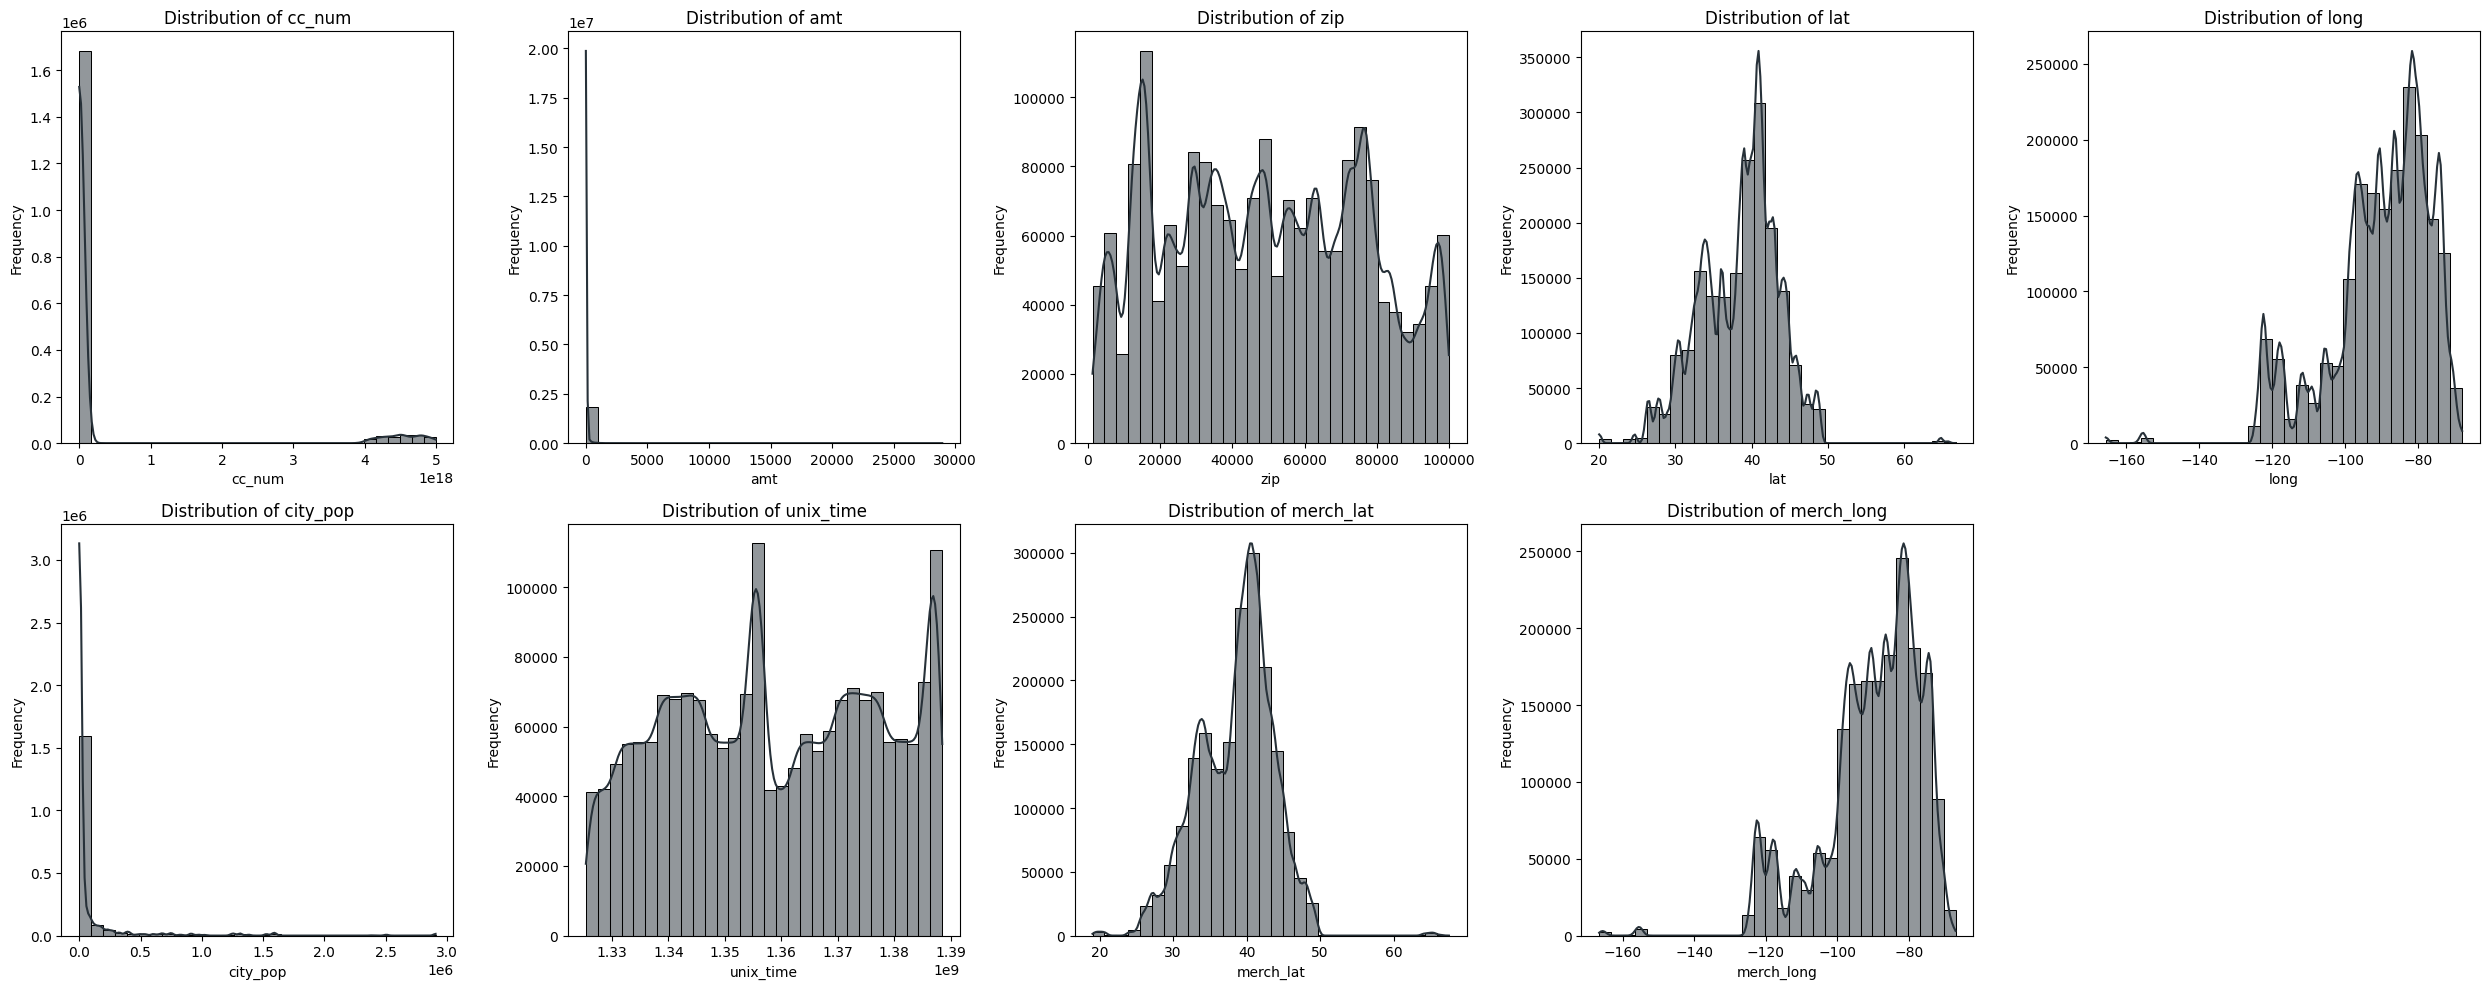

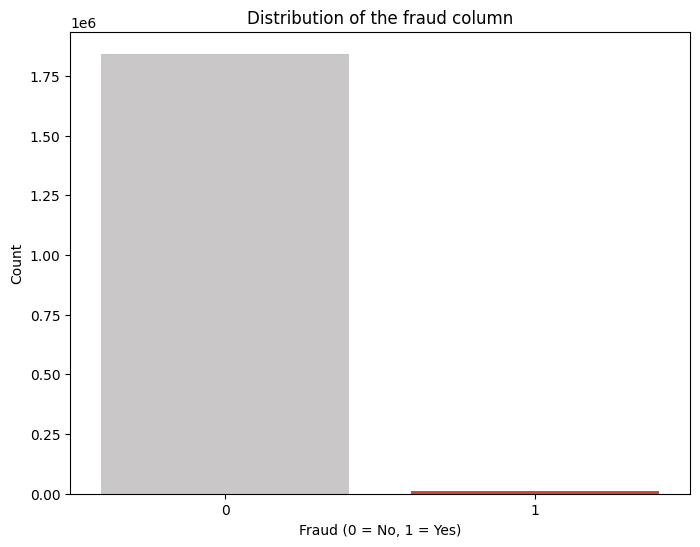

In [45]:
eda = EDA(cleaned_data)  
eda.visualize_data_distribution() 
eda.visualize_data_distribution_target()


<h5 style="color: black; font-weight;">2.3 | Visualiazations of the features with the target</h5>

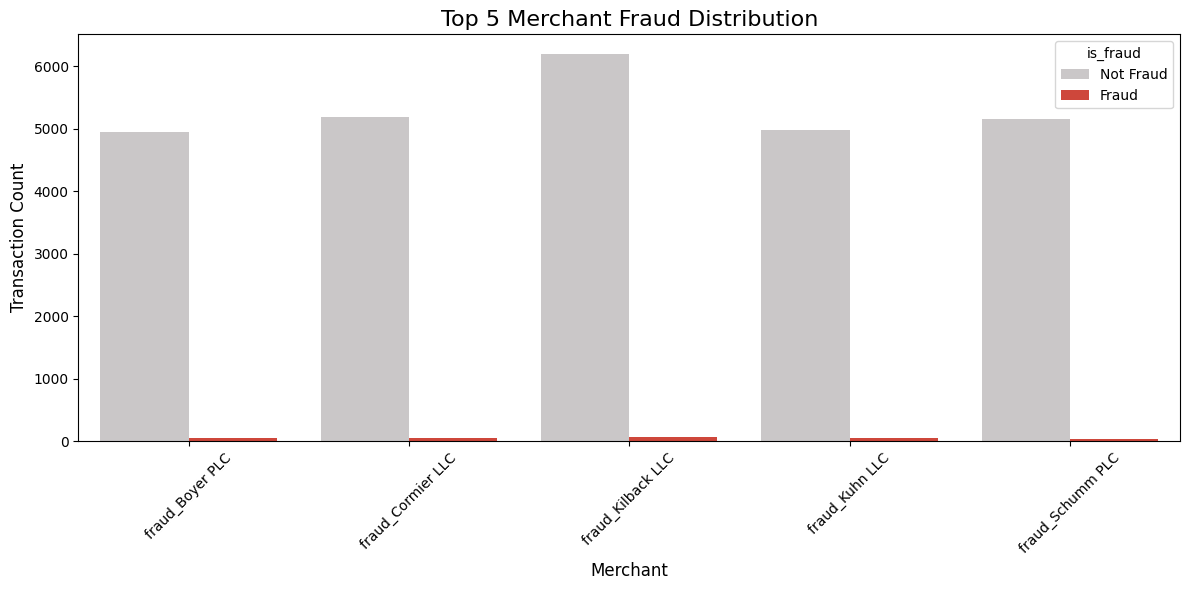

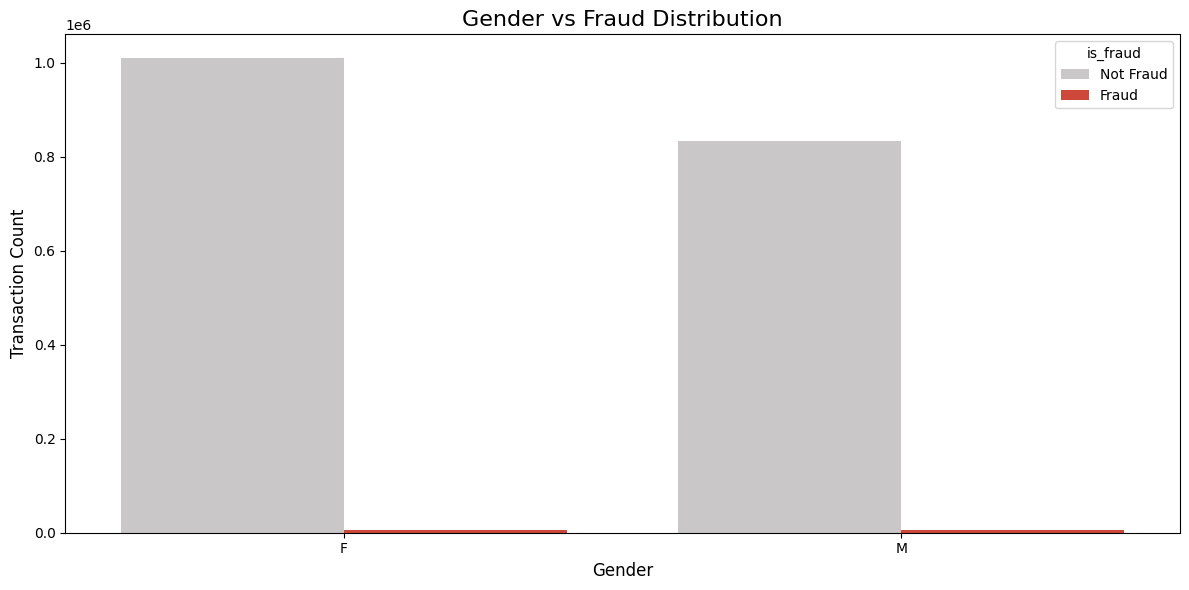

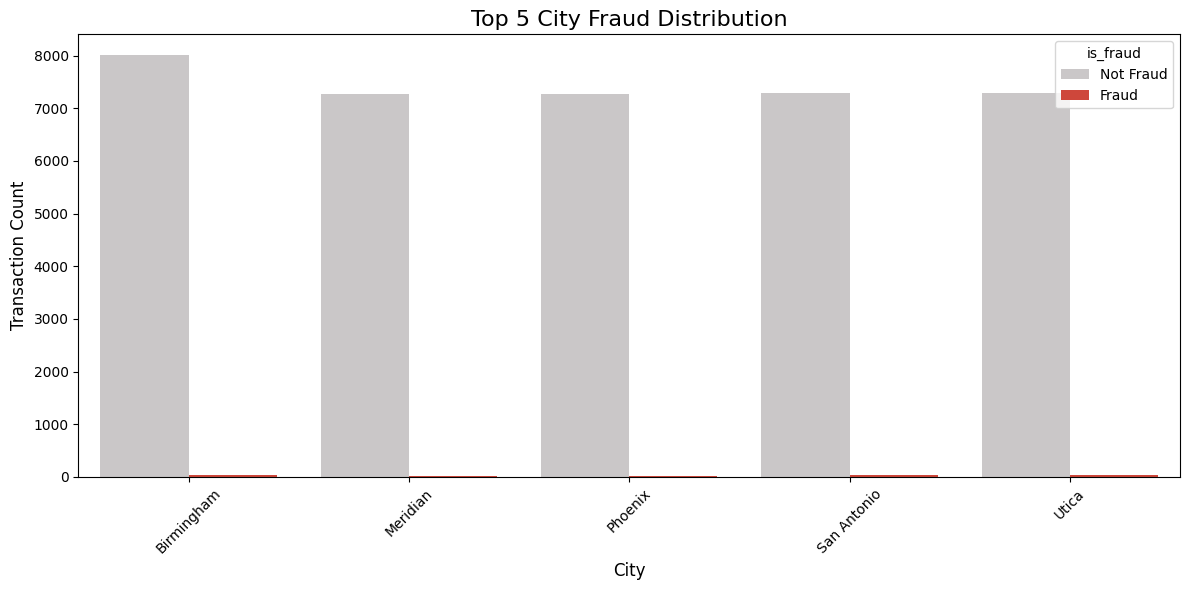

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

class EDAVisualizations:
    def __init__(self, data):
        self.data = data
    
    def plot_top_merchants_fraud_distribution(self):
        palette = ['#cac7c8', '#E63323']
        top_merchants = self.data['merchant'].value_counts().head(5).index
        filtered_data = self.data[self.data['merchant'].isin(top_merchants)]
        grouped_data = filtered_data.groupby(['is_fraud', 'merchant']).size().reset_index(name='Count')
        grouped_data['is_fraud'] = grouped_data['is_fraud'].map({0: 'Not Fraud', 1: 'Fraud'})
        grouped_data['Percentage'] = grouped_data.groupby('merchant')['Count'].transform(lambda x: 100 * x / x.sum())

        plt.figure(figsize=(12, 6))
        sns.barplot(x='merchant', y='Count', hue='is_fraud', data=grouped_data, palette=palette)

        plt.title('Top 5 Merchant Fraud Distribution', fontsize=16)
        plt.xlabel('Merchant', fontsize=12)
        plt.ylabel('Transaction Count', fontsize=12)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def plot_gender_fraud_distribution(self):
        palette = ['#cac7c8', '#E63323']
        grouped_data_gender = self.data.groupby(['is_fraud', 'gender']).size().reset_index(name='Count')
        grouped_data_gender['is_fraud'] = grouped_data_gender['is_fraud'].map({0: 'Not Fraud', 1: 'Fraud'})
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x='gender', y='Count', hue='is_fraud', data=grouped_data_gender, palette=palette)

        plt.title('Gender vs Fraud Distribution', fontsize=16)
        plt.xlabel('Gender', fontsize=12)
        plt.ylabel('Transaction Count', fontsize=12)
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()

    def plot_top_city_fraud_distribution(self):
        palette = ['#cac7c8', '#E63323']
        top_city = self.data['city'].value_counts().head().index
        filtered_data = self.data[self.data['city'].isin(top_city)]
        grouped_data = filtered_data.groupby(['is_fraud', 'city']).size().reset_index(name='Count')
        grouped_data['is_fraud'] = grouped_data['is_fraud'].map({0: 'Not Fraud', 1: 'Fraud'})


        plt.figure(figsize=(12, 6))
        sns.barplot(x='city', y='Count', hue='is_fraud', data=grouped_data, palette=palette)

        plt.title('Top 5 City Fraud Distribution', fontsize=16)
        plt.xlabel('City', fontsize=12)
        plt.ylabel('Transaction Count', fontsize=12)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

eda_vis = EDAVisualizations(cleaned_data)

# Gerar os gráficos
eda_vis.plot_top_merchants_fraud_distribution()
eda_vis.plot_gender_fraud_distribution()
eda_vis.plot_top_city_fraud_distribution()


<h5 style="color: black; font-weight;">2.4 | Using Chi Square to check the association of categorical variables with the target (is fraud column)</h5>

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency # chisquare test (non-parametric)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

class HypothesisTesting:
    
    def __init__(self, cleaned_data, categorical_features, target_variable):
        self.cleaned_data = cleaned_data
        self.categorical_features = categorical_features
        self.target_variable = target_variable
        
        self.cleaned_data[self.target_variable] = self.cleaned_data[self.target_variable].replace({1: 'Yes', 0: 'No'})

    def chi_square_test(self):
        # Chi-square tests for categorical features vs target variable
        for feature in self.categorical_features:
            contingency_table = pd.crosstab(self.cleaned_data[feature], self.cleaned_data[self.target_variable])
            
            # Chi-squared test
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            
            print(f'\nChi-square test for {feature} vs {self.target_variable}:')
            print("p-value:", p)
            
            # Considering that the alpha is 5%
            significance_level = 0.05
            # If the p-value is smaller than the significance level, we reject the H_0
            if p < significance_level:
                print(f"There is a significant association between {feature} and {self.target_variable}.")
            else:
                print(f"There is no significant association between {feature} and {self.target_variable}.")
    

categorical_features = ['merchant','category','first','last','gender','street','city','state','job']
target_variable = 'is_fraud'
ht = HypothesisTesting(cleaned_data, categorical_features, target_variable)
ht.chi_square_test()



Chi-square test for merchant vs is_fraud:
p-value: 0.0
There is a significant association between merchant and is_fraud.

Chi-square test for category vs is_fraud:
p-value: 0.0
There is a significant association between category and is_fraud.

Chi-square test for first vs is_fraud:
p-value: 0.0
There is a significant association between first and is_fraud.

Chi-square test for last vs is_fraud:
p-value: 0.0
There is a significant association between last and is_fraud.

Chi-square test for gender vs is_fraud:
p-value: 1.97369744724312e-15
There is a significant association between gender and is_fraud.

Chi-square test for street vs is_fraud:
p-value: 0.0
There is a significant association between street and is_fraud.

Chi-square test for city vs is_fraud:
p-value: 0.0
There is a significant association between city and is_fraud.

Chi-square test for state vs is_fraud:
p-value: 0.0
There is a significant association between state and is_fraud.

Chi-square test for job vs is_fraud:
p-val

In [48]:
cleaned_data

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.08,-81.18,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.01,-82.05,No
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.89,-118.21,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.16,-118.19,No
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.18,-112.26,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.15,-112.15,No
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.23,-112.11,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.03,-112.56,No
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.42,-79.46,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.67,-78.63,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,Luray,MO,63453,40.49,-91.89,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.95,-91.33,No
1852390,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,TX,77566,29.04,-95.44,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.66,-96.19,No
1852391,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,WA,99323,46.20,-118.90,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.66,-119.72,No
1852392,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,ID,83643,44.63,-116.45,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.47,-117.08,No


<h5 style="color: black; font-weight;">3.2 | Transforming Categorical variables </h5>

In [49]:
import pandas as pd

class DataPreprocessor:
    def __init__(self, cleaned_data):
        self.cleaned_data = cleaned_data
        self.cleaned_data_ohe = pd.DataFrame()  # DataFrame para o One-Hot Encoding
        
    # Casting binary variables to 0 and 1
    def cast_binary_variables(self):
        self.cleaned_data['is_fraud'] = self.cleaned_data['is_fraud'].replace({'Yes': 1, 'No': 0}).astype('Int64')
        self.cleaned_data['gender'] = self.cleaned_data['gender'].replace({'F': 1, 'M': 0}).astype('Int64')
        return self.cleaned_data
    
    # merging the columns first and last
    def merge_name_columns(self):
        self.cleaned_data['name'] = self.cleaned_data['first'] + ' ' + self.cleaned_data['last']
        return self.cleaned_data

    # frequency + one hot encoding for categorical 
    def apply_frequency_encoding(self):
        columns_to_encode = ['street', 'city', 'job', 'state', 'name', 'merchant','category']
        for column in columns_to_encode:
            column_counts = self.cleaned_data[column].value_counts()
            column_freq_mean = column_counts.mean()
            self.cleaned_data_ohe[f'{column}_category'] = self.cleaned_data[column].map(
                lambda x: 1 if column_counts[x] > column_freq_mean else 0
            )
        return self.cleaned_data_ohe

    #  date_extraction for trans_date_trans_time + dob columns
    def extract_date_features(self):
        # Asegure-se de que as colunas de data estejam no formato correto
        self.cleaned_data['trans_date_trans_time'] = pd.to_datetime(self.cleaned_data['trans_date_trans_time'])
        self.cleaned_data['dob'] = pd.to_datetime(self.cleaned_data['dob'])
        self.cleaned_data_ohe['trans_day'] = self.cleaned_data['trans_date_trans_time'].dt.day
        self.cleaned_data_ohe['trans_month'] = self.cleaned_data['trans_date_trans_time'].dt.month
        self.cleaned_data_ohe['trans_year'] = self.cleaned_data['trans_date_trans_time'].dt.year

        self.cleaned_data_ohe['dob_day'] = self.cleaned_data['dob'].dt.day
        self.cleaned_data_ohe['dob_month'] = self.cleaned_data['dob'].dt.month
        self.cleaned_data_ohe['dob_year'] = self.cleaned_data['dob'].dt.year
        return self.cleaned_data_ohe
    
    def preprocess_data(self):
        self.cast_binary_variables()
        self.merge_name_columns()
        self.apply_frequency_encoding()
        self.extract_date_features()
        return self.cleaned_data_ohe, self.cleaned_data

In [50]:
preprocessor = DataPreprocessor(cleaned_data)
cleaned_data_ohe, cleaned_data = preprocessor.preprocess_data()
# Agora você pode usar os dados processados
cleaned_data_ohe

,street_category,city_category,job_category,state_category,name_category,merchant_category,category_category,trans_day,trans_month,trans_year,dob_day,dob_month,dob_year
0,1,1,1,1,1,0,0,1,1,2019,9,3,1988
1,1,1,1,0,1,1,1,1,1,2019,21,6,1978
2,0,0,0,0,0,0,1,1,1,2019,19,1,1962
3,0,0,0,0,0,1,1,1,1,2019,12,1,1967
4,1,1,0,1,1,0,0,1,1,2019,28,3,1986
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,1,1,1,1,1,0,0,31,12,2020,13,2,1966
1852390,1,1,1,1,1,1,1,31,12,2020,27,12,1999
1852391,1,1,1,0,1,1,1,31,12,2020,29,11,1981
1852392,1,1,0,0,1,0,0,31,12,2020,15,12,1965


<h5 style="color: black; font-weight;">3.3 | Correlation Matrix </h5>

Combined Dataframe contains1852394 linesand 36 columns.
Heatmap with combined data


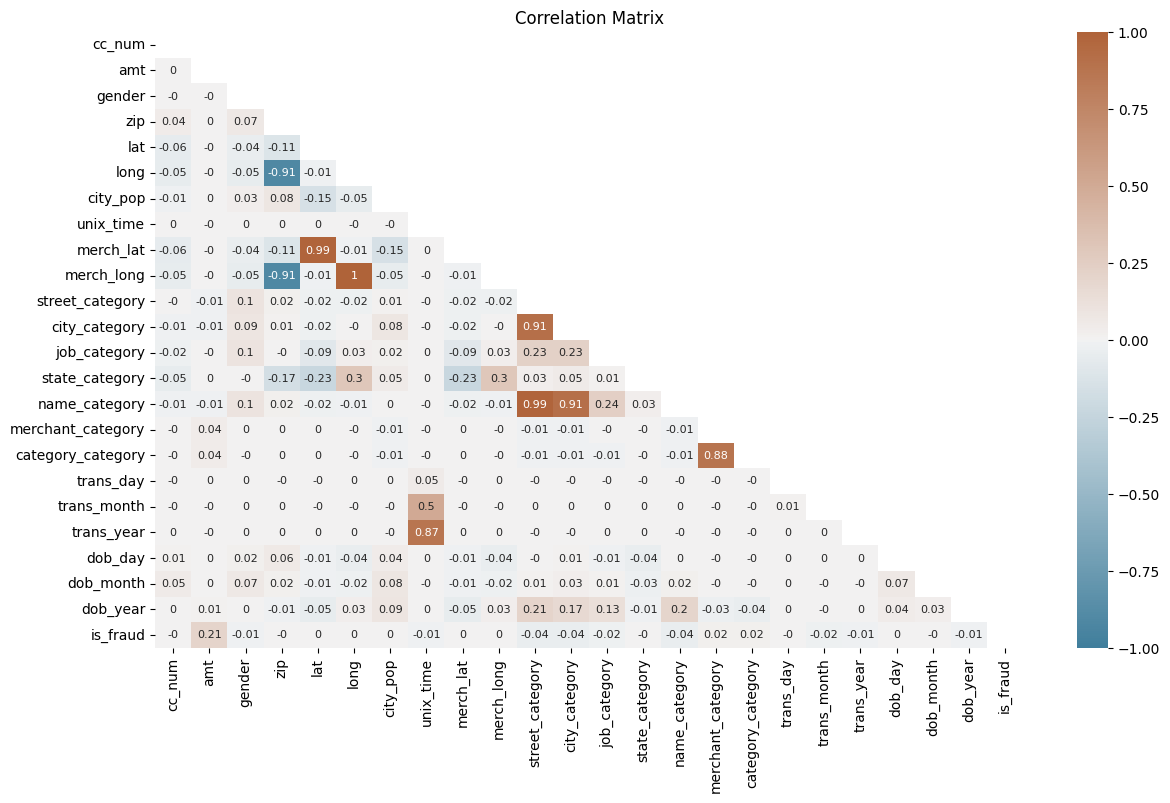

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

class CorrelationHeatmap:
    def __init__(self, cleaned_data_ohe, cleaned_data):
        self.cleaned_data_ohe = cleaned_data_ohe
        self.cleaned_data = cleaned_data
        self.move_is_fraud_to_end()

    def move_is_fraud_to_end(self):
        if 'is_fraud' in self.cleaned_data.columns:
            is_fraud_column = self.cleaned_data.pop('is_fraud')
            self.cleaned_data['is_fraud'] = is_fraud_column
        else:
            print("The column'is_fraud' is not present in cleaned_data.")

    def plot_heatmap(self, combined_data):
        numeric_data = combined_data.select_dtypes(include=[np.int32, np.int64, np.float64])
        if 'is_fraud' in numeric_data.columns:
            is_fraud_column = numeric_data.pop('is_fraud')
            numeric_data['is_fraud'] = is_fraud_column
        
        
        corr = numeric_data.corr(method='pearson').round(2)
        mask = np.triu(np.ones_like(corr, dtype=bool))
        plt.figure(figsize=(14, 8))
        sns.heatmap(corr, mask=mask, annot=True, cmap=sns.diverging_palette(230, 30, as_cmap=True),
                    vmin=-1, vmax=1, center=0, annot_kws={"fontsize": 8})
        plt.title("Correlation Matrix")
        plt.show()

    def analyze_combined_dataframes(self):
        combined_data = pd.concat([self.cleaned_data, self.cleaned_data_ohe], axis=1)
        if combined_data.empty:
            print("The Dataframe is empty")
            return None
        print(f"Combined Dataframe contains{combined_data.shape[0]} linesand {combined_data.shape[1]} columns.")
        
        print("Heatmap with combined data")
        self.plot_heatmap(combined_data)
        
        return None 

heatmap_generator = CorrelationHeatmap(cleaned_data_ohe, cleaned_data)
heatmap_generator.analyze_combined_dataframes()


<h5 style="color: black; font-weight;">3.4 | Dealing with Multicolinearity </h5>

In [52]:
import pandas as pd
import numpy as np

# Classe para análise de multicolinearidade
class MulticollinearityAnalysis:
    def __init__(self, cleaned_data_ohe, cleaned_data):
        self.cleaned_data_ohe = cleaned_data_ohe
        self.cleaned_data = cleaned_data

    def detect_multicollinearity(self, combined_data):
        # Filtra apenas as colunas numéricas
        numeric_data = combined_data.select_dtypes(include=[np.int32, np.int64, np.float64])
        corr_matrix = numeric_data.corr()
        high_corr = corr_matrix[(corr_matrix.abs() > 0.7) & (corr_matrix != 1)]
        high_corr_pairs = high_corr.stack()
        
        if not high_corr_pairs.empty:
            print("Pares de variáveis com alta correlação (> 0.7):")
            print(high_corr_pairs)
        else:
            print("Não há pares de variáveis com correlação > 0.7.")

    def analyze_combined_dataframes(self):
        combined_data = pd.concat([self.cleaned_data, self.cleaned_data_ohe], axis=1)
        if combined_data.empty:
            print("O DataFrame combinado está vazio.")
            return None

        print(f"DataFrame combinado contém {combined_data.shape[0]} linhas e {combined_data.shape[1]} colunas.")
        self.detect_multicollinearity(combined_data)
        
        return combined_data

multicollinearity_analyzer = MulticollinearityAnalysis(cleaned_data_ohe, cleaned_data)
multicollinearity_analyzer.analyze_combined_dataframes()

DataFrame combinado contém 1852394 linhas e 36 colunas.
Pares de variáveis com alta correlação (> 0.7):
zip                long                -0.91
                   merch_long          -0.91
lat                merch_lat            0.99
long               zip                 -0.91
                   merch_long           1.00
unix_time          trans_year           0.87
merch_lat          lat                  0.99
merch_long         zip                 -0.91
                   long                 1.00
street_category    city_category        0.91
                   name_category        0.99
city_category      street_category      0.91
                   name_category        0.91
name_category      street_category      0.99
                   city_category        0.91
merchant_category  category_category    0.88
category_category  merchant_category    0.88
trans_year         unix_time            0.87
dtype: float64


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,name,is_fraud,street_category,city_category,job_category,state_category,name_category,merchant_category,category_category,trans_day,trans_month,trans_year,dob_day,dob_month,dob_year
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,1,561 Perry Cove,Moravian Falls,NC,28654,36.08,-81.18,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.01,-82.05,Jennifer Banks,0,1,1,1,1,1,0,0,1,1,2019,9,3,1988
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,1,43039 Riley Greens Suite 393,Orient,WA,99160,48.89,-118.21,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.16,-118.19,Stephanie Gill,0,1,1,1,0,1,1,1,1,1,2019,21,6,1978
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,0,594 White Dale Suite 530,Malad City,ID,83252,42.18,-112.26,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.15,-112.15,Edward Sanchez,0,0,0,0,0,0,0,1,1,1,2019,19,1,1962
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,0,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.23,-112.11,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.03,-112.56,Jeremy White,0,0,0,0,0,0,1,1,1,1,2019,12,1,1967
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,0,408 Bradley Rest,Doe Hill,VA,24433,38.42,-79.46,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.67,-78.63,Tyler Garcia,0,1,1,0,1,1,0,0,1,1,2019,28,3,1986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,0,558 Michael Estates,Luray,MO,63453,40.49,-91.89,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.95,-91.33,Michael Olson,0,1,1,1,1,1,0,0,31,12,2020,13,2,1966
1852390,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,0,572 Davis Mountains,Lake Jackson,TX,77566,29.04,-95.44,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.66,-96.19,Jose Vasquez,0,1,1,1,1,1,1,1,31,12,2020,27,12,1999
1852391,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,1,144 Evans Islands Apt. 683,Burbank,WA,99323,46.20,-118.90,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.66,-119.72,Ann Lawson,0,1,1,1,0,1,1,1,31,12,2020,29,11,1981
1852392,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,0,7020 Doyle Stream Apt. 951,Mesa,ID,83643,44.63,-116.45,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.47,-117.08,Eric Preston,0,1,1,0,0,1,0,0,31,12,2020,15,12,1965


<h5 style="color: black; font-weight: bold;"> 3 | Feature Engineering </h5>

In [53]:
import pandas as pd
from geopy.distance import geodesic

class FeatureEngineering:
    def __init__(self, cleaned_data, cleaned_data_ohe):
        self.cleaned_data = cleaned_data
        self.cleaned_data_ohe = cleaned_data_ohe
        self.cleaned_combined_data = None
        
    def combine_data(self):
        # Concatenate cleaned data with one-hot encoded data
        self.cleaned_combined_data = pd.concat([self.cleaned_data, self.cleaned_data_ohe], axis=1)
        
    def add_time_features(self):
        # Extract hour and day of week from transaction timestamp
        self.cleaned_data_ohe['trans_date_trans_time_hour'] = self.cleaned_data['trans_date_trans_time'].dt.hour
        self.cleaned_data_ohe['trans_time_hour_day_of_week'] = self.cleaned_data['trans_date_trans_time'].dt.dayofweek
        
        # Add weekend feature (1 for weekend, 0 for weekday)
        self.cleaned_data_ohe['trans_date_trans_time_is_weekend'] = self.cleaned_data_ohe['trans_time_hour_day_of_week'].apply(
            lambda x: 1 if x >= 5 else 0
        )
        
    def calculate_time_since_last_transaction(self):
        # Sort by credit card number and transaction date
        self.cleaned_data = self.cleaned_data.sort_values(by=['cc_num', 'trans_date_trans_time'])
        
        # Calculate time since the last transaction for each user
        self.cleaned_data['time_since_last'] = (
            self.cleaned_data.groupby('cc_num')['trans_date_trans_time']
            .diff().dt.total_seconds().fillna(0)
        )
        
    def add_amt_features(self):
        # Add mean transaction amount per customer
        self.cleaned_data_ohe['amt_mean_by_customer'] = self.cleaned_data.groupby('cc_num')['amt'].transform('mean')
        
        # Add ratio of the transaction amount to the mean transaction amount
        self.cleaned_data_ohe['amt_to_mean_ratio'] = self.cleaned_data['amt'] / self.cleaned_data_ohe['amt_mean_by_customer']
        
    def calculate_distance_to_merchant(self):
        # Calculate distance to merchant using geodesic distance
        self.cleaned_data_ohe['distance_to_merchant'] = self.cleaned_data.apply(
            lambda row: geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).km, axis=1
        )
        
    def calculate_time_diff(self):
        # Calculate time difference in unix time
        self.cleaned_data_ohe['time_diff'] = self.cleaned_data['unix_time'].diff().fillna(0)
        
        # Group by credit card number and calculate time difference
        self.cleaned_data_ohe['time_diff'] = self.cleaned_data.groupby('cc_num')['unix_time'].diff().fillna(0)
        
    def add_small_city_feature(self):
        self.cleaned_data_ohe['is_small_city'] = (self.cleaned_data['city_pop'] < 100000).astype(int)
        
    def add_combined_category_feature(self):
        # Combine city, name, and street categories into a single feature
        self.cleaned_data_ohe['CT_NA_STR_CG'] = self.cleaned_data_ohe[['city_category', 'name_category', 'street_category']].sum(axis=1) / 3
        
    def transform(self):
        # Apply all transformations
        self.add_time_features()
        self.calculate_time_since_last_transaction()
        self.add_amt_features()
        self.calculate_distance_to_merchant()
        self.calculate_time_diff()
        self.add_small_city_feature()
        self.add_combined_category_feature()
        
        # Combine the cleaned_data and cleaned_data_ohe after all transformations
        self.combine_data()
        
        # Return the final combined DataFrame
        return self.cleaned_combined_data


feature_engineering = FeatureEngineering(cleaned_data, cleaned_data_ohe)
cleaned_combined_data = feature_engineering.transform()
cleaned_combined_data


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,name,is_fraud,time_since_last,street_category,city_category,job_category,state_category,name_category,merchant_category,category_category,trans_day,trans_month,trans_year,dob_day,dob_month,dob_year,trans_date_trans_time_hour,trans_time_hour_day_of_week,trans_date_trans_time_is_weekend,amt_mean_by_customer,amt_to_mean_ratio,distance_to_merchant,time_diff,is_small_city,CT_NA_STR_CG
1017,2019-01-01 12:47:15,60416207185,"fraud_Jones, Sawayn and Romaguera",misc_net,7.27,Mary,Diaz,1,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,1645,Information systems manager,1986-02-17,98e3dcf98101146a577f85a34e58feec,1325422035,43.97,-109.74,Mary Diaz,0,0.00,1,1,0,0,1,0,0,1,1,2019,17,2,1986,12,1,0,59.26,0.12,127.63,0.00,1,1.00
2724,2019-01-02 08:44:57,60416207185,fraud_Berge LLC,gas_transport,52.94,Mary,Diaz,1,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,1645,Information systems manager,1986-02-17,498120fc45d277f7c88e3dba79c33865,1325493897,42.02,-109.04,Mary Diaz,0,71862.00,1,1,0,0,1,1,1,2,1,2019,17,2,1986,8,2,0,59.26,0.89,110.20,71862.00,1,1.00
2726,2019-01-02 08:47:36,60416207185,fraud_Luettgen PLC,gas_transport,82.08,Mary,Diaz,1,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,1645,Information systems manager,1986-02-17,95f514bb993151347c7acdf8505c3d62,1325494056,42.96,-109.16,Mary Diaz,0,159.00,1,1,0,0,1,1,1,2,1,2019,17,2,1986,8,2,0,59.26,1.39,21.84,159.00,1,1.00
2882,2019-01-02 12:38:14,60416207185,fraud_Daugherty LLC,kids_pets,34.79,Mary,Diaz,1,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,1645,Information systems manager,1986-02-17,4f0c1a14e0aa7eb56a490780ef9268c5,1325507894,42.23,-108.75,Mary Diaz,0,13838.00,1,1,0,0,1,1,1,2,1,2019,17,2,1986,12,2,0,59.26,0.59,87.12,13838.00,1,1.00
2907,2019-01-02 13:10:46,60416207185,fraud_Beier and Sons,home,27.18,Mary,Diaz,1,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,1645,Information systems manager,1986-02-17,3b2ebd3af508afba959640893e1e82bc,1325509846,43.32,-108.09,Mary Diaz,0,1952.00,1,1,0,0,1,1,1,2,1,2019,17,2,1986,13,2,0,59.26,0.46,74.35,1952.00,1,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849259,2020-12-31 02:10:10,4992346398065154184,fraud_Parisian and Sons,gas_transport,66.11,Benjamin,Kim,0,920 Patrick Light,Mc Nabb,IL,61335,41.17,-89.22,532,Audiological scientist,1956-01-09,4620efdc6130bbbc9007b66e77021545,1388455810,40.92,-88.81,Benjamin Kim,0,8077.00,1,1,1,1,1,1,1,31,12,2020,9,1,1956,2,3,0,66.46,0.99,44.93,8077.00,1,1.00
1849567,2020-12-31 05:13:35,4992346398065154184,fraud_Bogisich-Homenick,misc_net,4.58,Benjamin,Kim,0,920 Patrick Light,Mc Nabb,IL,61335,41.17,-89.22,532,Audiological scientist,1956-01-09,e3d43c233659781065e17d4c5655cb88,1388466815,40.64,-89.88,Benjamin Kim,0,11005.00,1,1,1,1,1,0,0,31,12,2020,9,1,1956,5,3,0,66.46,0.07,81.53,11005.00,1,1.00
1850234,2020-12-31 11:15:44,4992346398065154184,fraud_Erdman-Kertzmann,gas_transport,95.96,Benjamin,Kim,0,920 Patrick Light,Mc Nabb,IL,61335,41.17,-89.22,532,Audiological scientist,1956-01-09,aab4f2a7e1eeb2bf3332db76bf955f66,1388488544,40.87,-89.07,Benjamin Kim,0,21729.00,1,1,1,1,1,1,1,31,12,2020,9,1,1956,11,3,0,66.46,1.44,36.02,21729.00,1,1.00
1850235,2020-12-31 11:17:25,4992346398065154184,fraud_Stracke-Lemke,grocery_pos,149.48,Benjamin,Kim,0,920 Patrick Light,Mc Nabb,IL,61335,41.17,-89.22,532,Audiological scientist,1956-01-09,90904857e6f31804e8c9c7716cdfd7ed,1388488645,41.44,-90.13,Benjamin Kim,0,101.00,1,1,1,1,1,1,1,31,12,2020,9,1,1956,11,3,0,66.46,2.25,81.94,101.00,1,1.00


<h5 style="color: black; font-weight: bold;">4 | Data Modeling </h5>

In [54]:
cleaned_combined_data_ml = cleaned_combined_data.copy()

<h5 style="color: black; font-weight;">Dealing with Multicolinearity to optimization </h5>

In [55]:
numeric_data = cleaned_combined_data_ml.select_dtypes(include=[np.int32, np.int64, np.float64])
corr_matrix = numeric_data.corr()
high_corr = corr_matrix[(corr_matrix.abs() > 0.7) & (corr_matrix != 1)]
high_corr_pairs = high_corr.stack()
if not high_corr_pairs.empty:
    print("Pares de variáveis com alta correlação (> 0.7):")
    print(high_corr_pairs)
else:
    print("Não há pares de variáveis com correlação > 0.7.")


Pares de variáveis com alta correlação (> 0.7):
amt                               amt_to_mean_ratio                   0.98
zip                               long                               -0.91
                                  merch_long                         -0.91
lat                               merch_lat                           0.99
long                              zip                                -0.91
                                  merch_long                          1.00
unix_time                         trans_year                          0.87
merch_lat                         lat                                 0.99
merch_long                        zip                                -0.91
                                  long                                1.00
time_since_last                   time_diff                           1.00
street_category                   city_category                       0.91
                                  name_category     

In [56]:
cleaned_combined_data_ml['Category_and_merchant_freq'] = ((cleaned_combined_data_ml['merchant_category'] + cleaned_combined_data_ml['category_category'])/2).round().astype(int)  # Converte para tipo inteiro
O_cleaned_combined_data_mL = cleaned_combined_data_ml.copy()
cleaned_combined_data_ml = cleaned_combined_data_ml[
    [col for col in cleaned_combined_data_ml.columns if col not in ['city_category', 'name_category', 'street_category', 'long', 'lat', 'merch_lat', 
                                                                    'merch_long','trans_date_trans_time_is_weekend','time_diff','category_category','merchant_category',
                                                                    'merchant','category','first','last','street','city','state','job','dob','trans_date_trans_time','name']]
]
is_fraud_column = cleaned_data.pop('is_fraud')
cleaned_data['is_fraud'] = is_fraud_column
cleaned_combined_data_ml

,cc_num,amt,gender,zip,city_pop,trans_num,unix_time,is_fraud,time_since_last,job_category,state_category,trans_day,trans_month,trans_year,dob_day,dob_month,dob_year,trans_date_trans_time_hour,trans_time_hour_day_of_week,amt_mean_by_customer,amt_to_mean_ratio,distance_to_merchant,is_small_city,CT_NA_STR_CG,Category_and_merchant_freq
1017,60416207185,7.27,1,82514,1645,98e3dcf98101146a577f85a34e58feec,1325422035,0,0.00,0,0,1,1,2019,17,2,1986,12,1,59.26,0.12,127.63,1,1.00,0
2724,60416207185,52.94,1,82514,1645,498120fc45d277f7c88e3dba79c33865,1325493897,0,71862.00,0,0,2,1,2019,17,2,1986,8,2,59.26,0.89,110.20,1,1.00,1
2726,60416207185,82.08,1,82514,1645,95f514bb993151347c7acdf8505c3d62,1325494056,0,159.00,0,0,2,1,2019,17,2,1986,8,2,59.26,1.39,21.84,1,1.00,1
2882,60416207185,34.79,1,82514,1645,4f0c1a14e0aa7eb56a490780ef9268c5,1325507894,0,13838.00,0,0,2,1,2019,17,2,1986,12,2,59.26,0.59,87.12,1,1.00,1
2907,60416207185,27.18,1,82514,1645,3b2ebd3af508afba959640893e1e82bc,1325509846,0,1952.00,0,0,2,1,2019,17,2,1986,13,2,59.26,0.46,74.35,1,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849259,4992346398065154184,66.11,0,61335,532,4620efdc6130bbbc9007b66e77021545,1388455810,0,8077.00,1,1,31,12,2020,9,1,1956,2,3,66.46,0.99,44.93,1,1.00,1
1849567,4992346398065154184,4.58,0,61335,532,e3d43c233659781065e17d4c5655cb88,1388466815,0,11005.00,1,1,31,12,2020,9,1,1956,5,3,66.46,0.07,81.53,1,1.00,0
1850234,4992346398065154184,95.96,0,61335,532,aab4f2a7e1eeb2bf3332db76bf955f66,1388488544,0,21729.00,1,1,31,12,2020,9,1,1956,11,3,66.46,1.44,36.02,1,1.00,1
1850235,4992346398065154184,149.48,0,61335,532,90904857e6f31804e8c9c7716cdfd7ed,1388488645,0,101.00,1,1,31,12,2020,9,1,1956,11,3,66.46,2.25,81.94,1,1.00,1


In [57]:
cleaned_combined_data_ml = cleaned_combined_data_ml.drop(columns='trans_num')

In [58]:
# Ajusta o número máximo de colunas a ser exibido
pd.set_option('display.max_columns', None)
cleaned_combined_data_ml.dtypes

cc_num                           int64
amt                            float64
gender                           Int64
zip                              int64
city_pop                         int64
unix_time                        int64
is_fraud                         Int64
time_since_last                float64
job_category                     int64
state_category                   int64
trans_day                        int32
trans_month                      int32
trans_year                       int32
dob_day                          int32
dob_month                        int32
dob_year                         int32
trans_date_trans_time_hour       int32
trans_time_hour_day_of_week      int32
amt_mean_by_customer           float64
amt_to_mean_ratio              float64
distance_to_merchant           float64
is_small_city                    int32
CT_NA_STR_CG                   float64
Category_and_merchant_freq       int32
dtype: object

In [59]:
import numpy as np

def recking_the_multicollinearity(dataframe, threshold=0.7):
    numeric_data = dataframe.select_dtypes(include=[np.int32, np.int64, np.float64])
    corr_matrix = numeric_data.corr()
    high_corr = corr_matrix[(corr_matrix.abs() > threshold) & (corr_matrix != 1)]
    high_corr_pairs = high_corr.stack()
    if not high_corr_pairs.empty:
        print(f"Pares de variáveis com alta correlação (> {threshold}):")
        print(high_corr_pairs)
    else:
        print(f"Não há pares de variáveis com correlação > {threshold}.")

recking_the_multicollinearity(cleaned_combined_data_ml, threshold=0.7)


Pares de variáveis com alta correlação (> 0.7):
amt                amt_to_mean_ratio   0.98
unix_time          trans_year          0.87
trans_year         unix_time           0.87
amt_to_mean_ratio  amt                 0.98
dtype: float64


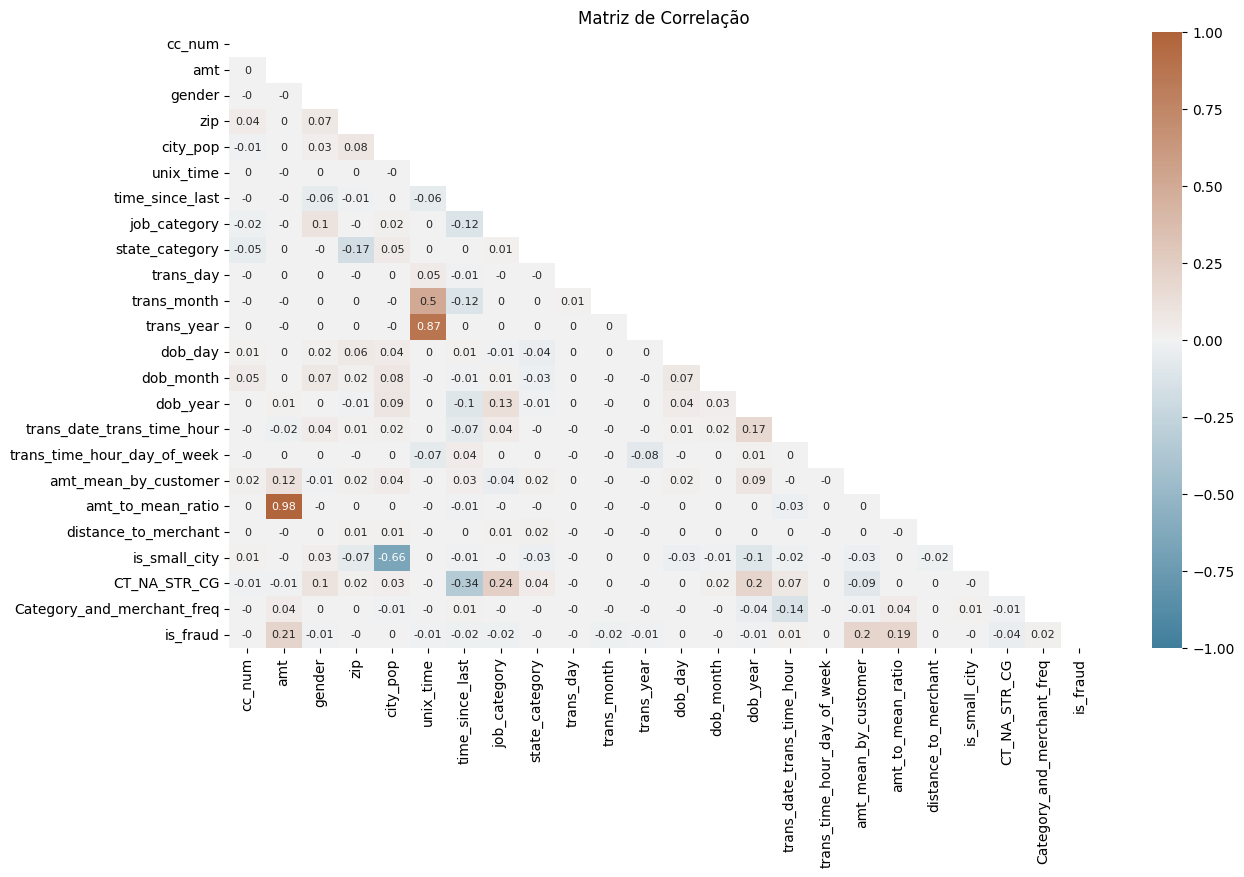

In [60]:
is_fraud_column = cleaned_combined_data_ml.pop('is_fraud')
cleaned_combined_data_ml = cleaned_combined_data_ml.assign(is_fraud=is_fraud_column)

numeric_data = cleaned_combined_data_ml.select_dtypes(include=[np.int32, np.int64, np.float64])
corr = numeric_data.corr(method='pearson').round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(14, 8))
sns.heatmap(corr, mask=mask, annot=True, cmap=sns.diverging_palette(230, 30, as_cmap=True),
vmin=-1, vmax=1, center=0, annot_kws={"fontsize": 8})
plt.title("Matriz de Correlação")
plt.show()


In [61]:
# Ajusta o número máximo de colunas a ser exibido
pd.set_option('display.max_columns', None)
cleaned_combined_data_ml



,cc_num,amt,gender,zip,city_pop,unix_time,time_since_last,job_category,state_category,trans_day,trans_month,trans_year,dob_day,dob_month,dob_year,trans_date_trans_time_hour,trans_time_hour_day_of_week,amt_mean_by_customer,amt_to_mean_ratio,distance_to_merchant,is_small_city,CT_NA_STR_CG,Category_and_merchant_freq,is_fraud
1017,60416207185,7.27,1,82514,1645,1325422035,0.00,0,0,1,1,2019,17,2,1986,12,1,59.26,0.12,127.63,1,1.00,0,0
2724,60416207185,52.94,1,82514,1645,1325493897,71862.00,0,0,2,1,2019,17,2,1986,8,2,59.26,0.89,110.20,1,1.00,1,0
2726,60416207185,82.08,1,82514,1645,1325494056,159.00,0,0,2,1,2019,17,2,1986,8,2,59.26,1.39,21.84,1,1.00,1,0
2882,60416207185,34.79,1,82514,1645,1325507894,13838.00,0,0,2,1,2019,17,2,1986,12,2,59.26,0.59,87.12,1,1.00,1,0
2907,60416207185,27.18,1,82514,1645,1325509846,1952.00,0,0,2,1,2019,17,2,1986,13,2,59.26,0.46,74.35,1,1.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849259,4992346398065154184,66.11,0,61335,532,1388455810,8077.00,1,1,31,12,2020,9,1,1956,2,3,66.46,0.99,44.93,1,1.00,1,0
1849567,4992346398065154184,4.58,0,61335,532,1388466815,11005.00,1,1,31,12,2020,9,1,1956,5,3,66.46,0.07,81.53,1,1.00,0,0
1850234,4992346398065154184,95.96,0,61335,532,1388488544,21729.00,1,1,31,12,2020,9,1,1956,11,3,66.46,1.44,36.02,1,1.00,1,0
1850235,4992346398065154184,149.48,0,61335,532,1388488645,101.00,1,1,31,12,2020,9,1,1956,11,3,66.46,2.25,81.94,1,1.00,1,0


<h5 style="color: black; font-weight: bold;">5 | Data Modeling </h5>

In [62]:
cleaned_combined_data_ml

,cc_num,amt,gender,zip,city_pop,unix_time,time_since_last,job_category,state_category,trans_day,trans_month,trans_year,dob_day,dob_month,dob_year,trans_date_trans_time_hour,trans_time_hour_day_of_week,amt_mean_by_customer,amt_to_mean_ratio,distance_to_merchant,is_small_city,CT_NA_STR_CG,Category_and_merchant_freq,is_fraud
1017,60416207185,7.27,1,82514,1645,1325422035,0.00,0,0,1,1,2019,17,2,1986,12,1,59.26,0.12,127.63,1,1.00,0,0
2724,60416207185,52.94,1,82514,1645,1325493897,71862.00,0,0,2,1,2019,17,2,1986,8,2,59.26,0.89,110.20,1,1.00,1,0
2726,60416207185,82.08,1,82514,1645,1325494056,159.00,0,0,2,1,2019,17,2,1986,8,2,59.26,1.39,21.84,1,1.00,1,0
2882,60416207185,34.79,1,82514,1645,1325507894,13838.00,0,0,2,1,2019,17,2,1986,12,2,59.26,0.59,87.12,1,1.00,1,0
2907,60416207185,27.18,1,82514,1645,1325509846,1952.00,0,0,2,1,2019,17,2,1986,13,2,59.26,0.46,74.35,1,1.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849259,4992346398065154184,66.11,0,61335,532,1388455810,8077.00,1,1,31,12,2020,9,1,1956,2,3,66.46,0.99,44.93,1,1.00,1,0
1849567,4992346398065154184,4.58,0,61335,532,1388466815,11005.00,1,1,31,12,2020,9,1,1956,5,3,66.46,0.07,81.53,1,1.00,0,0
1850234,4992346398065154184,95.96,0,61335,532,1388488544,21729.00,1,1,31,12,2020,9,1,1956,11,3,66.46,1.44,36.02,1,1.00,1,0
1850235,4992346398065154184,149.48,0,61335,532,1388488645,101.00,1,1,31,12,2020,9,1,1956,11,3,66.46,2.25,81.94,1,1.00,1,0


<h2 style="color: #FF6347;">X-Y Split</h2>

In [63]:
X = cleaned_combined_data_ml.drop(columns=['is_fraud'])  
y = cleaned_combined_data_ml['is_fraud'] 

<h2 style="color: #FF6347;">Train-Test Split</h2>

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Training features shape: {X_train.shape}, Test features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}, Test target shape: {y_test.shape}")

Training features shape: (1296675, 23), Test features shape: (555719, 23)
Training target shape: (1296675,), Test target shape: (555719,)


In [65]:
final_source = X_test.copy()
final_source['is_fraud'] = y_test
final_source

,cc_num,amt,gender,zip,city_pop,unix_time,time_since_last,job_category,state_category,trans_day,trans_month,trans_year,dob_day,dob_month,dob_year,trans_date_trans_time_hour,trans_time_hour_day_of_week,amt_mean_by_customer,amt_to_mean_ratio,distance_to_merchant,is_small_city,CT_NA_STR_CG,Category_and_merchant_freq,is_fraud
492932,6011148190095209,43.57,1,94015,107941,1344000894,37669.00,1,1,3,8,2019,4,10,1991,13,5,91.70,0.48,44.11,0,1.00,1,0
506802,4355790796238264643,66.17,0,62360,1656,1344397125,60383.00,1,1,8,8,2019,4,8,1969,3,3,64.34,1.03,135.10,1,1.00,1,0
913925,30343344410970,61.89,0,16239,4172,1356803969,9726.00,1,1,29,12,2019,20,3,1962,17,6,67.93,0.91,103.08,1,1.00,0,0
968850,4979422371139333,6.09,1,68881,73,1359224129,3753.00,0,0,26,1,2020,10,2,1935,18,6,72.03,0.08,55.05,1,1.00,0,0
1375910,180046617132290,76.17,1,62939,3119,1374213249,98697.00,0,1,19,7,2020,17,4,1942,5,6,70.37,1.08,88.89,1,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306740,4836998673805450,2.19,1,49854,6469,1372036168,4326.00,1,1,24,6,2020,12,4,1979,1,2,92.42,0.02,72.04,1,1.00,0,0
503927,6592861994408652,44.53,1,14037,1166,1344278243,942.00,1,1,6,8,2019,12,6,1983,18,1,55.92,0.80,70.52,1,1.00,0,0
1839836,4169388510116,48.79,1,14537,207,1388276006,12068.00,0,1,29,12,2020,27,9,1962,0,1,62.33,0.78,110.59,1,1.00,1,0
445800,676248282243,63.28,1,33909,156391,1342523318,31103.00,0,1,17,7,2019,9,2,1968,11,2,64.67,0.98,130.01,0,0.00,1,0


<h2 style="color: #FF6347;">MinMaxScaler</h2>


In [66]:
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler(feature_range=(0, 1))
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [67]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
X_resampled = X_train
y_resampled = y_train

In [68]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
X_resampled = X_train
y_resampled = y_train

In [69]:
X_resampled

,cc_num,amt,gender,zip,city_pop,unix_time,time_since_last,job_category,state_category,trans_day,trans_month,trans_year,dob_day,dob_month,dob_year,trans_date_trans_time_hour,trans_time_hour_day_of_week,amt_mean_by_customer,amt_to_mean_ratio,distance_to_merchant,is_small_city,CT_NA_STR_CG,Category_and_merchant_freq
0,0.00,0.00,1.00,0.76,0.00,0.28,0.01,1.00,1.00,20,7,2019,4,3,1978,3,5,0.01,0.00,0.36,1,1.00,1
1,0.00,0.00,1.00,0.54,0.00,0.99,0.00,0.00,1.00,22,12,2020,23,11,1997,18,1,0.00,0.00,0.57,1,1.00,1
2,0.00,0.00,0.00,0.03,0.00,0.84,0.01,1.00,0.00,6,9,2020,2,3,1956,0,6,0.01,0.00,0.51,1,1.00,1
3,0.00,0.00,0.00,0.06,0.00,0.25,0.03,1.00,0.00,30,6,2019,30,6,1965,22,6,0.02,0.00,0.61,1,1.00,0
4,0.00,0.00,1.00,0.38,0.01,0.75,0.00,1.00,0.00,5,7,2020,24,12,1984,13,6,0.05,0.00,0.49,1,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2579741,0.00,0.02,0.00,0.57,0.00,0.02,0.00,1.00,0.00,17,1,2019,13,3,1970,23,3,0.02,0.02,0.23,1,1.00,0
2579742,0.00,0.03,0.64,0.47,0.00,0.93,0.01,1.00,1.00,12,11,2020,5,2,1956,22,3,0.02,0.04,0.39,1,0.12,0
2579743,0.00,0.00,1.00,0.67,0.00,0.71,0.00,0.20,1.00,26,7,2019,26,2,1986,23,5,0.02,0.00,0.79,1,0.00,1
2579744,0.00,0.00,0.00,0.58,0.00,0.39,0.04,1.00,0.00,9,10,2019,1,5,1991,22,2,0.05,0.00,0.41,1,0.00,0


In [70]:
final_dataframe_analysis = pd.DataFrame(X_resampled.copy())
final_dataframe_analysis['is_fraud'] = y_resampled.copy()
final_dataframe_analysis


,cc_num,amt,gender,zip,city_pop,unix_time,time_since_last,job_category,state_category,trans_day,trans_month,trans_year,dob_day,dob_month,dob_year,trans_date_trans_time_hour,trans_time_hour_day_of_week,amt_mean_by_customer,amt_to_mean_ratio,distance_to_merchant,is_small_city,CT_NA_STR_CG,Category_and_merchant_freq,is_fraud
0,0.00,0.00,1.00,0.76,0.00,0.28,0.01,1.00,1.00,20,7,2019,4,3,1978,3,5,0.01,0.00,0.36,1,1.00,1,0
1,0.00,0.00,1.00,0.54,0.00,0.99,0.00,0.00,1.00,22,12,2020,23,11,1997,18,1,0.00,0.00,0.57,1,1.00,1,0
2,0.00,0.00,0.00,0.03,0.00,0.84,0.01,1.00,0.00,6,9,2020,2,3,1956,0,6,0.01,0.00,0.51,1,1.00,1,0
3,0.00,0.00,0.00,0.06,0.00,0.25,0.03,1.00,0.00,30,6,2019,30,6,1965,22,6,0.02,0.00,0.61,1,1.00,0,0
4,0.00,0.00,1.00,0.38,0.01,0.75,0.00,1.00,0.00,5,7,2020,24,12,1984,13,6,0.05,0.00,0.49,1,1.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2579741,0.00,0.02,0.00,0.57,0.00,0.02,0.00,1.00,0.00,17,1,2019,13,3,1970,23,3,0.02,0.02,0.23,1,1.00,0,1
2579742,0.00,0.03,0.64,0.47,0.00,0.93,0.01,1.00,1.00,12,11,2020,5,2,1956,22,3,0.02,0.04,0.39,1,0.12,0,1
2579743,0.00,0.00,1.00,0.67,0.00,0.71,0.00,0.20,1.00,26,7,2019,26,2,1986,23,5,0.02,0.00,0.79,1,0.00,1,1
2579744,0.00,0.00,0.00,0.58,0.00,0.39,0.04,1.00,0.00,9,10,2019,1,5,1991,22,2,0.05,0.00,0.41,1,0.00,0,1


In [71]:
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler(feature_range=(0, 1))
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

lazy_clf = LazyClassifier()
models = lazy_clf.fit(X_resampled, X_test, y_resampled, y_test)
print(models[0])

<h2 style="color: #FF6347;">Unbalanced Data </h2>

In [72]:
balanced_data = pd.DataFrame(X_resampled, columns=X_train.columns)
balanced_data['is_fraud'] = y_resampled
data = balanced_datasmote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
X_resampled = X_train
y_resampled = y_train
y_resampled.value_counts()



is_fraud
0    1289873
1    1289873
Name: count, dtype: Int64

<h2 style="color: #FF6347;">MinMaxScaler</h2>

numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler(feature_range=(0, 1))
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train, y_train = undersampler.fit_resample(X_train, y_train)
X_resampled = X_train
y_resampled = y_train
balanced_data = pd.DataFrame(X_resampled, columns=X_resampled.columns)
balanced_data['is_fraud'] = y_resampled
print(y_train.value_counts())


lazy_clf = LazyClassifier()
models = lazy_clf.fit(X_resampled, X_test, y_resampled, y_test)
print(models[0])

<h2 style="color: #FF6347;">Model Selection: Logistic Regression</h2>

In [73]:
model = LogisticRegression()
model.fit(X_resampled,y_resampled)

LogisticRegression()

<h2 style="color: #FF6347;">Model Validation</h2>

In [74]:
predictions = model.predict(X_test)
print(f'30% for test prediction data: {len(predictions)}.')

30% for test prediction data: 555719.


In [75]:
print("Logistic Regression Classification Report:")
lr = print(classification_report(y_test, predictions))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.65      0.79    552870
         1.0       0.01      0.57      0.02      2849

    accuracy                           0.65    555719
   macro avg       0.50      0.61      0.40    555719
weighted avg       0.99      0.65      0.78    555719



<h2 style="color: #FF6347;">Model Selection: Random Forest</h2>

In [76]:
rf_model = RandomForestClassifier()

In [77]:
rf_model = RandomForestClassifier(n_estimators=100,  # Number of trees
                                max_depth=20,     # Maximum depth of the trees
                                min_samples_split=5,  # Minimum samples to split
                                min_samples_leaf=2,   # Minimum samples in each leaf
                                random_state=321,
                                n_jobs=-1)  # Use all available processors

# 3. Fit the model to the training data
rf_model.fit(X_resampled,y_resampled)

# 4. Make predictions on the test set
rf_predictions = rf_model.predict(X_test)

# 5. Print Classification Report
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions))



Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    552870
         1.0       0.38      0.79      0.51      2849

    accuracy                           0.99    555719
   macro avg       0.69      0.89      0.75    555719
weighted avg       1.00      0.99      0.99    555719



<h2 style="color: #FF6347;">Model Selection: XGboost</h2>

In [78]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_resampled, y_resampled)

print("Model train com sucesso!")

Modelo treinado com sucesso!


In [79]:
import xgboost as xgb
from sklearn.metrics import classification_report

# Inicializar o modelo XGBoost com hiperparâmetros definidos
xgb_model = xgb.XGBClassifier(
    n_estimators=100,        # Número de árvores
    max_depth=20,            # Profundidade máxima das árvores
    min_child_weight=1,      # Peso mínimo da criança
    learning_rate=0.2,       # Taxa de aprendizado
    subsample=0.5,           # Subamostragem das amostras de treinamento
    colsample_bytree=0.5,    # Subamostragem das features
    random_state=321,        # Semente para reprodução
    n_jobs=-1                # Uso de todos os núcleos disponíveis
)

# Treinar o modelo com os dados ajustados (X_resampled e y_resampled)
xgb_model.fit(X_resampled, y_resampled)

# Fazer previsões no conjunto de testes
xgb_predictions = xgb_model.predict(X_test)

# Exibir o relatório de classificação
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_predictions))



XGBoost Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552870
         1.0       0.86      0.81      0.83      2849

    accuracy                           1.00    555719
   macro avg       0.93      0.91      0.92    555719
weighted avg       1.00      1.00      1.00    555719



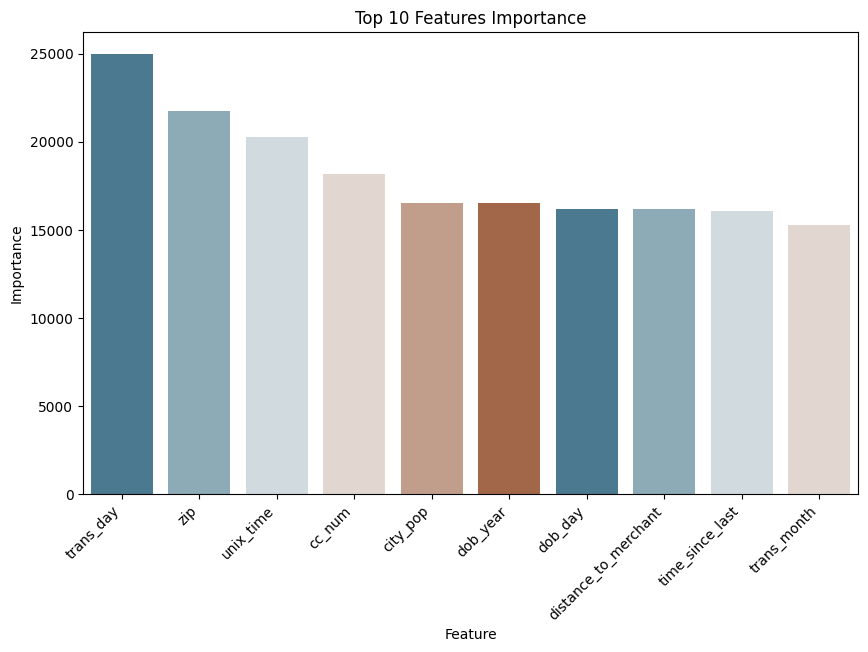

In [80]:
importance = xgb_model.get_booster().get_score(importance_type='weight')

importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])

importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Importance', data=importance_df.head(10), 
            palette=sns.diverging_palette(230, 30))

plt.title('Top 10 Features Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right') 
plt.show()

In [81]:
from sklearn.metrics import roc_curve, roc_auc_score
probs = xgb_model.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, probs[:, 1])  # A coluna 1 contém as probabilidades da classe positiva (fraude)
auc = roc_auc_score(y_test, probs[:, 1])  # Cálculo da área sob a curva (AUC)
print(f"AUC: {auc:.4f}")

AUC: 0.9956


Acurácia no Teste: 0.9983
Recall no Teste: 0.8122
Especificidade no Teste: 0.9993


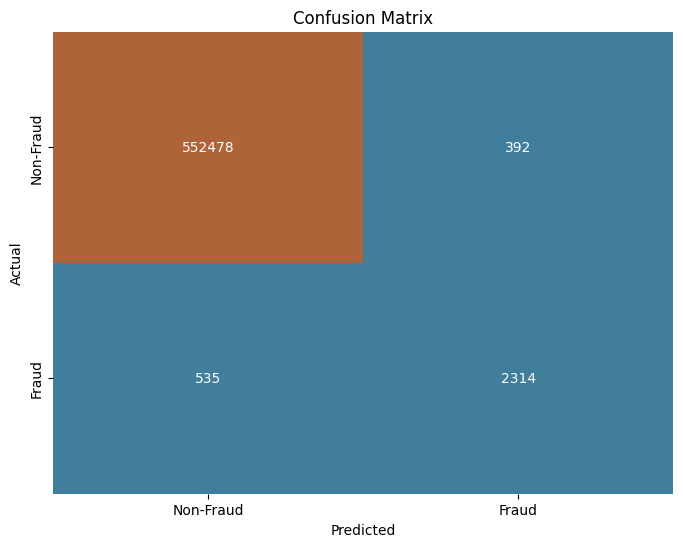

True Negatives (TN): 552478
False Positives (FP): 392
False Negatives (FN): 535
True Positives (TP): 2314


In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular a matriz de confusão
cm = confusion_matrix(y_test, xgb_predictions)

# Obter os valores de TN, FP, FN, TP
TN, FP, FN, TP = cm.ravel()

# Calcular as métricas
acuracia = (TP + TN) / (TP + TN + FP + FN)  # Acurácia
recall = TP / (TP + FN)  # Recall (ou Sensibilidade)
especificidade = TN / (TN + FP)  # Especificidade

# Exibir as métricas
print(f"Acurácia no Teste: {acuracia:.4f}")
print(f"Recall no Teste: {recall:.4f}")
print(f"Especificidade no Teste: {especificidade:.4f}")

# Plotar a matriz de confusão com a paleta divergente
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap=sns.diverging_palette(230, 30, as_cmap=True), cbar=False, 
            xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])

# Adicionar rótulos e título
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Mostrar o gráfico
plt.show()

# Exibir os valores de TN, FP, FN, TP
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")


In [83]:
xgb_train_predictions = xgb_model.predict(X_resampled)
cm_train = confusion_matrix(y_resampled, xgb_train_predictions)
TN_train, FP_train, FN_train, TP_train = cm_train.ravel()

acuracia_train = (TP_train + TN_train) / (TP_train + TN_train + FP_train + FN_train)  # Acurácia
recall_train = TP_train / (TP_train + FN_train)  # Recall (ou Sensibilidade)
especificidade_train = TN_train / (TN_train + FP_train)  # Especificidade

print(f"Acurácia no Treinamento: {acuracia_train:.4f}")
print(f"Recall no Treinamento: {recall_train:.4f}")
print(f"Especificidade no Treinamento: {especificidade_train:.4f}")


Acurácia no Treinamento: 1.0000
Recall no Treinamento: 1.0000
Especificidade no Treinamento: 1.0000


In [84]:
# Obter as probabilidades das previsões
probs = xgb_model.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva (fraude)

# Testar diferentes thresholds
thresholds = np.arange(0.5, 1.0, 0.05)
best_f1 = 0
best_threshold = 0

for t in thresholds:
    preds = (probs >= t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"Melhor threshold: {best_threshold}")


Melhor threshold: 0.6500000000000001


In [85]:
# Matriz de confusão para o conjunto de testes
cm = confusion_matrix(y_test, xgb_predictions)
TN, FP, FN, TP = cm.ravel()

# Calcular as métricas
acuracia = (TP + TN) / (TP + TN + FP + FN)
recall = TP / (TP + FN)
especificidade = TN / (TN + FP)

# Exibir as métricas
print(f"Acurácia: {acuracia:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Especificidade: {especificidade:.4f}")

# Calcular AUC
auc_score = roc_auc_score(y_test, probs)
print(f"AUC: {auc_score:.4f}")


Acurácia: 0.9983
Recall: 0.8122
Especificidade: 0.9993
AUC: 0.9956


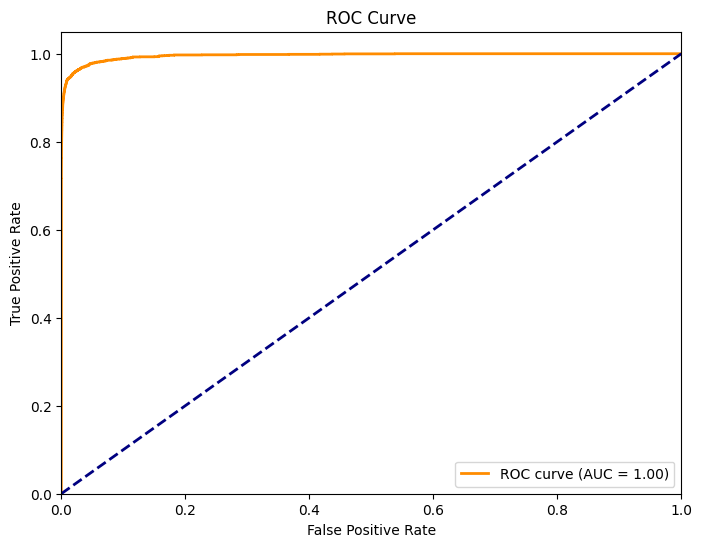

In [86]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()



In [87]:
balanced_data # training data
X_test # test data

,cc_num,amt,gender,zip,city_pop,unix_time,time_since_last,job_category,state_category,trans_day,trans_month,trans_year,dob_day,dob_month,dob_year,trans_date_trans_time_hour,trans_time_hour_day_of_week,amt_mean_by_customer,amt_to_mean_ratio,distance_to_merchant,is_small_city,CT_NA_STR_CG,Category_and_merchant_freq
492932,0.00,0.00,1.00,0.94,0.04,0.29,0.03,1.00,1.00,3,8,2019,4,10,1991,13,5,0.05,0.00,0.29,0,1.00,1
506802,0.87,0.00,0.00,0.62,0.00,0.30,0.05,1.00,1.00,8,8,2019,4,8,1969,3,3,0.02,0.00,0.90,1,1.00,1
913925,0.00,0.00,0.00,0.15,0.00,0.50,0.01,1.00,1.00,29,12,2019,20,3,1962,17,6,0.02,0.00,0.68,1,1.00,0
968850,0.00,0.00,1.00,0.69,0.00,0.54,0.00,0.00,0.00,26,1,2020,10,2,1935,18,6,0.03,0.00,0.37,1,1.00,0
1375910,0.00,0.00,1.00,0.63,0.00,0.77,0.08,0.00,1.00,19,7,2020,17,4,1942,5,6,0.03,0.00,0.59,1,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306740,0.00,0.00,1.00,0.49,0.00,0.74,0.00,1.00,1.00,24,6,2020,12,4,1979,1,2,0.05,0.00,0.48,1,1.00,0
503927,0.00,0.00,1.00,0.13,0.00,0.30,0.00,1.00,1.00,6,8,2019,12,6,1983,18,1,0.01,0.00,0.47,1,1.00,0
1839836,0.00,0.00,1.00,0.13,0.00,1.00,0.01,0.00,1.00,29,12,2020,27,9,1962,0,1,0.02,0.00,0.73,1,1.00,1
445800,0.00,0.00,1.00,0.33,0.05,0.27,0.03,0.00,1.00,17,7,2019,9,2,1968,11,2,0.02,0.00,0.86,0,0.00,1


In [91]:
xgb_predictions_df = pd.DataFrame(xgb_predictions)
xgb_predictions_df.shape

(555719, 1)

In [89]:
final_source

,cc_num,amt,gender,zip,city_pop,unix_time,time_since_last,job_category,state_category,trans_day,trans_month,trans_year,dob_day,dob_month,dob_year,trans_date_trans_time_hour,trans_time_hour_day_of_week,amt_mean_by_customer,amt_to_mean_ratio,distance_to_merchant,is_small_city,CT_NA_STR_CG,Category_and_merchant_freq,is_fraud
492932,6011148190095209,43.57,1,94015,107941,1344000894,37669.00,1,1,3,8,2019,4,10,1991,13,5,91.70,0.48,44.11,0,1.00,1,0
506802,4355790796238264643,66.17,0,62360,1656,1344397125,60383.00,1,1,8,8,2019,4,8,1969,3,3,64.34,1.03,135.10,1,1.00,1,0
913925,30343344410970,61.89,0,16239,4172,1356803969,9726.00,1,1,29,12,2019,20,3,1962,17,6,67.93,0.91,103.08,1,1.00,0,0
968850,4979422371139333,6.09,1,68881,73,1359224129,3753.00,0,0,26,1,2020,10,2,1935,18,6,72.03,0.08,55.05,1,1.00,0,0
1375910,180046617132290,76.17,1,62939,3119,1374213249,98697.00,0,1,19,7,2020,17,4,1942,5,6,70.37,1.08,88.89,1,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306740,4836998673805450,2.19,1,49854,6469,1372036168,4326.00,1,1,24,6,2020,12,4,1979,1,2,92.42,0.02,72.04,1,1.00,0,0
503927,6592861994408652,44.53,1,14037,1166,1344278243,942.00,1,1,6,8,2019,12,6,1983,18,1,55.92,0.80,70.52,1,1.00,0,0
1839836,4169388510116,48.79,1,14537,207,1388276006,12068.00,0,1,29,12,2020,27,9,1962,0,1,62.33,0.78,110.59,1,1.00,1,0
445800,676248282243,63.28,1,33909,156391,1342523318,31103.00,0,1,17,7,2019,9,2,1968,11,2,64.67,0.98,130.01,0,0.00,1,0


In [93]:
final_source= final_source.reset_index(drop=True)
final_source["xgb_predictions"]= xgb_predictions_df
final_source.to_csv('final_source.csv', index=False)
final_source

,cc_num,amt,gender,zip,city_pop,unix_time,time_since_last,job_category,state_category,trans_day,trans_month,trans_year,dob_day,dob_month,dob_year,trans_date_trans_time_hour,trans_time_hour_day_of_week,amt_mean_by_customer,amt_to_mean_ratio,distance_to_merchant,is_small_city,CT_NA_STR_CG,Category_and_merchant_freq,is_fraud,xgb_predictions
0,6011148190095209,43.57,1,94015,107941,1344000894,37669.00,1,1,3,8,2019,4,10,1991,13,5,91.70,0.48,44.11,0,1.00,1,0,0
1,4355790796238264643,66.17,0,62360,1656,1344397125,60383.00,1,1,8,8,2019,4,8,1969,3,3,64.34,1.03,135.10,1,1.00,1,0,0
2,30343344410970,61.89,0,16239,4172,1356803969,9726.00,1,1,29,12,2019,20,3,1962,17,6,67.93,0.91,103.08,1,1.00,0,0,0
3,4979422371139333,6.09,1,68881,73,1359224129,3753.00,0,0,26,1,2020,10,2,1935,18,6,72.03,0.08,55.05,1,1.00,0,0,0
4,180046617132290,76.17,1,62939,3119,1374213249,98697.00,0,1,19,7,2020,17,4,1942,5,6,70.37,1.08,88.89,1,0.00,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,4836998673805450,2.19,1,49854,6469,1372036168,4326.00,1,1,24,6,2020,12,4,1979,1,2,92.42,0.02,72.04,1,1.00,0,0,0
555715,6592861994408652,44.53,1,14037,1166,1344278243,942.00,1,1,6,8,2019,12,6,1983,18,1,55.92,0.80,70.52,1,1.00,0,0,0
555716,4169388510116,48.79,1,14537,207,1388276006,12068.00,0,1,29,12,2020,27,9,1962,0,1,62.33,0.78,110.59,1,1.00,1,0,0
555717,676248282243,63.28,1,33909,156391,1342523318,31103.00,0,1,17,7,2019,9,2,1968,11,2,64.67,0.98,130.01,0,0.00,1,0,0


In [94]:
pip install pyodbc

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [96]:
final_source

,cc_num,amt,gender,zip,city_pop,unix_time,time_since_last,job_category,state_category,trans_day,trans_month,trans_year,dob_day,dob_month,dob_year,trans_date_trans_time_hour,trans_time_hour_day_of_week,amt_mean_by_customer,amt_to_mean_ratio,distance_to_merchant,is_small_city,CT_NA_STR_CG,Category_and_merchant_freq,is_fraud,xgb_predictions
0,6011148190095209,43.57,1,94015,107941,1344000894,37669.00,1,1,3,8,2019,4,10,1991,13,5,91.70,0.48,44.11,0,1.00,1,0,0
1,4355790796238264643,66.17,0,62360,1656,1344397125,60383.00,1,1,8,8,2019,4,8,1969,3,3,64.34,1.03,135.10,1,1.00,1,0,0
2,30343344410970,61.89,0,16239,4172,1356803969,9726.00,1,1,29,12,2019,20,3,1962,17,6,67.93,0.91,103.08,1,1.00,0,0,0
3,4979422371139333,6.09,1,68881,73,1359224129,3753.00,0,0,26,1,2020,10,2,1935,18,6,72.03,0.08,55.05,1,1.00,0,0,0
4,180046617132290,76.17,1,62939,3119,1374213249,98697.00,0,1,19,7,2020,17,4,1942,5,6,70.37,1.08,88.89,1,0.00,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,4836998673805450,2.19,1,49854,6469,1372036168,4326.00,1,1,24,6,2020,12,4,1979,1,2,92.42,0.02,72.04,1,1.00,0,0,0
555715,6592861994408652,44.53,1,14037,1166,1344278243,942.00,1,1,6,8,2019,12,6,1983,18,1,55.92,0.80,70.52,1,1.00,0,0,0
555716,4169388510116,48.79,1,14537,207,1388276006,12068.00,0,1,29,12,2020,27,9,1962,0,1,62.33,0.78,110.59,1,1.00,1,0,0
555717,676248282243,63.28,1,33909,156391,1342523318,31103.00,0,1,17,7,2019,9,2,1968,11,2,64.67,0.98,130.01,0,0.00,1,0,0


In [97]:
import pandas as pd
from sqlalchemy import create_engine

# Dados da conexão
server = 'Marcela\\SQLEXPRESS'  # Substitua pelo nome do seu servidor
database = 'TRANSACTIONS_final'

# Crie a engine do SQLAlchemy para conexão ao SQL Server
engine = create_engine(f'mssql+pyodbc://{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server')

# Exportar os dados para o SQL Server
final_source.to_sql('final_source', con=engine, if_exists='replace', index=False)

print("Dados exportados com sucesso!")


Dados exportados com sucesso!


In [98]:
cleaned_combined_data

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,name,is_fraud,time_since_last,street_category,city_category,job_category,state_category,name_category,merchant_category,category_category,trans_day,trans_month,trans_year,dob_day,dob_month,dob_year,trans_date_trans_time_hour,trans_time_hour_day_of_week,trans_date_trans_time_is_weekend,amt_mean_by_customer,amt_to_mean_ratio,distance_to_merchant,time_diff,is_small_city,CT_NA_STR_CG
1017,2019-01-01 12:47:15,60416207185,"fraud_Jones, Sawayn and Romaguera",misc_net,7.27,Mary,Diaz,1,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,1645,Information systems manager,1986-02-17,98e3dcf98101146a577f85a34e58feec,1325422035,43.97,-109.74,Mary Diaz,0,0.00,1,1,0,0,1,0,0,1,1,2019,17,2,1986,12,1,0,59.26,0.12,127.63,0.00,1,1.00
2724,2019-01-02 08:44:57,60416207185,fraud_Berge LLC,gas_transport,52.94,Mary,Diaz,1,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,1645,Information systems manager,1986-02-17,498120fc45d277f7c88e3dba79c33865,1325493897,42.02,-109.04,Mary Diaz,0,71862.00,1,1,0,0,1,1,1,2,1,2019,17,2,1986,8,2,0,59.26,0.89,110.20,71862.00,1,1.00
2726,2019-01-02 08:47:36,60416207185,fraud_Luettgen PLC,gas_transport,82.08,Mary,Diaz,1,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,1645,Information systems manager,1986-02-17,95f514bb993151347c7acdf8505c3d62,1325494056,42.96,-109.16,Mary Diaz,0,159.00,1,1,0,0,1,1,1,2,1,2019,17,2,1986,8,2,0,59.26,1.39,21.84,159.00,1,1.00
2882,2019-01-02 12:38:14,60416207185,fraud_Daugherty LLC,kids_pets,34.79,Mary,Diaz,1,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,1645,Information systems manager,1986-02-17,4f0c1a14e0aa7eb56a490780ef9268c5,1325507894,42.23,-108.75,Mary Diaz,0,13838.00,1,1,0,0,1,1,1,2,1,2019,17,2,1986,12,2,0,59.26,0.59,87.12,13838.00,1,1.00
2907,2019-01-02 13:10:46,60416207185,fraud_Beier and Sons,home,27.18,Mary,Diaz,1,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,1645,Information systems manager,1986-02-17,3b2ebd3af508afba959640893e1e82bc,1325509846,43.32,-108.09,Mary Diaz,0,1952.00,1,1,0,0,1,1,1,2,1,2019,17,2,1986,13,2,0,59.26,0.46,74.35,1952.00,1,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849259,2020-12-31 02:10:10,4992346398065154184,fraud_Parisian and Sons,gas_transport,66.11,Benjamin,Kim,0,920 Patrick Light,Mc Nabb,IL,61335,41.17,-89.22,532,Audiological scientist,1956-01-09,4620efdc6130bbbc9007b66e77021545,1388455810,40.92,-88.81,Benjamin Kim,0,8077.00,1,1,1,1,1,1,1,31,12,2020,9,1,1956,2,3,0,66.46,0.99,44.93,8077.00,1,1.00
1849567,2020-12-31 05:13:35,4992346398065154184,fraud_Bogisich-Homenick,misc_net,4.58,Benjamin,Kim,0,920 Patrick Light,Mc Nabb,IL,61335,41.17,-89.22,532,Audiological scientist,1956-01-09,e3d43c233659781065e17d4c5655cb88,1388466815,40.64,-89.88,Benjamin Kim,0,11005.00,1,1,1,1,1,0,0,31,12,2020,9,1,1956,5,3,0,66.46,0.07,81.53,11005.00,1,1.00
1850234,2020-12-31 11:15:44,4992346398065154184,fraud_Erdman-Kertzmann,gas_transport,95.96,Benjamin,Kim,0,920 Patrick Light,Mc Nabb,IL,61335,41.17,-89.22,532,Audiological scientist,1956-01-09,aab4f2a7e1eeb2bf3332db76bf955f66,1388488544,40.87,-89.07,Benjamin Kim,0,21729.00,1,1,1,1,1,1,1,31,12,2020,9,1,1956,11,3,0,66.46,1.44,36.02,21729.00,1,1.00
1850235,2020-12-31 11:17:25,4992346398065154184,fraud_Stracke-Lemke,grocery_pos,149.48,Benjamin,Kim,0,920 Patrick Light,Mc Nabb,IL,61335,41.17,-89.22,532,Audiological scientist,1956-01-09,90904857e6f31804e8c9c7716cdfd7ed,1388488645,41.44,-90.13,Benjamin Kim,0,101.00,1,1,1,1,1,1,1,31,12,2020,9,1,1956,11,3,0,66.46,2.25,81.94,101.00,1,1.00


In [99]:
import pandas as pd
from sqlalchemy import create_engine

# Dados da conexão
server = 'Marcela\\SQLEXPRESS'  # Substitua pelo nome do seu servidor
database = 'TRANSACTIONS_final'

# Crie a engine do SQLAlchemy para conexão ao SQL Server
engine = create_engine(f'mssql+pyodbc://{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server')

# Exportar os dados para o SQL Server
cleaned_combined_data.to_sql('cleaned_combined_data', con=engine, if_exists='replace', index=False)

print("Dados exportados com sucesso!")

Dados exportados com sucesso!


In [55]:
import pandas as pd
from sqlalchemy import create_engine

# Configurações do servidor SQL Server
server = 'Marcela\SQLEXPRESS'  # Nome do seu servidor SQL Server
database = 'TRANSACTIONS'      # Nome do banco de dados

# Crie a engine de conexão usando o SQLAlchemy
engine = create_engine(
    f'mssql+pyodbc://{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server'
)

# Certifique-se de que o DataFrame 'final' está definido
# Exemplo de DataFrame

# Exporta o DataFrame para o SQL Server
final.to_sql('final', con=engine, if_exists='replace', index=False)

print("Dados exportados com sucesso!")

cleaned_combined_data_ml

Dados exportados com sucesso!


In [56]:
import mysql.connector
user = root
host= 'localhost:3306'
password = 1234
database = 'TRANSACTIONS'
# Defina suas credenciais do MySQL

# Criando um cursor para executar consultas SQL
cursor = connection.cursor()

# Execute uma consulta SQL
cursor.execute("SELECT * FROM sua_tabela")

# Obter os resultados da consulta
results = cursor.fetchall()
print("Resultados da consulta:")
for row in results:
    print(row)

# Fechar a conexão
connection.close()


NameError: name 'root' is not defined